### Forecasting comparison

In [58]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(lubridate)
    library(tsibble)
    library(fable)
    library(gtools)
    library(feasts)
})

In [33]:
source("../functions/utils.R")

In [2]:
proj_lc <- readRDS("../data/projections/county_final.rds")
acs_1 <- readRDS("../data/prepped_data/counties_1_acs.rds")

In [3]:
proj_lc <- proj_lc %>%
    mutate(lig = log(ig_count_imptd)) %>%
    select(countyid, year, lprd_4, lu90_4, ll90_4, lig)
acs_1 <- acs_1 %>%
    mutate(lcens = log(chh_)) %>%
    select(countyid, year, lcens)

In [6]:
proj_data <- proj_lc %>%
    inner_join(acs_1)
print(dim(proj_data))
head(proj_data)

Joining, by = c("countyid", "year")



[1] 10049     7


countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02020,2006,11.73739,11.81662,11.65536,11.63390,11.535489
02090,2006,10.58351,10.64255,10.52372,10.53617,10.239460
02170,2006,10.24220,10.29857,10.18445,10.36999,9.980911
01003,2006,11.04422,11.08120,11.00628,11.13041,11.162332
01015,2006,10.74821,10.77806,10.71801,10.69643,10.747272
01043,2006,10.33379,10.35934,10.30790,10.33615,10.340225


In [28]:
train <- proj_data %>%
    filter(year != 2018)
test <- proj_data %>% 
    filter(year == 2018)

In [14]:
train <- train %>% 
    as_tsibble(index = year, key = countyid)

### Test out modelling approach on one county

In [15]:
fit <- train %>%
    model(lm = TSLM(lcens ~ trend()))

In [31]:
fc <- fit %>% 
    forecast(h = 1) %>%
    hilo(level = 90) %>%
    unpack_hilo("90%") %>%
    select(-lcens, -year)
head(fc)

countyid,.model,.mean,90%_lower,90%_upper,year
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
01003,lm,11.24982,11.16869,11.33096,2018
01015,lm,10.68949,10.65901,10.71998,2018
01043,lm,10.33550,10.28973,10.38126,2018
01049,lm,10.14409,10.05033,10.23784,2018
01051,lm,10.32790,10.25408,10.40171,2018
01055,lm,10.52820,10.49308,10.56332,2018


In [37]:
res <- test %>%
    left_join(fc)
head(res)

Joining, by = c("countyid", "year")



countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens,.model,.mean,90%_lower,90%_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
01003,2018,11.36932,11.41209,11.32499,11.45257,11.33261,lm,11.24982,11.16869,11.33096
01015,2018,10.75054,10.78046,10.72039,10.69892,10.69793,lm,10.68949,10.65901,10.71998
01043,2018,10.40459,10.43099,10.37785,10.40644,10.31966,lm,10.33550,10.28973,10.38126
01049,2018,10.15802,10.18265,10.13330,10.15070,10.18347,lm,10.14409,10.05033,10.23784
01051,2018,10.31920,10.34614,10.29193,10.34609,10.31411,lm,10.32790,10.25408,10.40171
01055,2018,10.62800,10.65655,10.59931,10.60681,10.56166,lm,10.52820,10.49308,10.56332


In [40]:
rbind(get_errors(res$lcens, res$.mean, "LSTM projection", round = TRUE),
      get_errors(res$lcens, res$lig, "Raw IG estimate", round = TRUE),
      get_errors(res$lcens, res$lprd_4, "Adjusted IG estimate", round = TRUE))

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LSTM projection,11.2864,0.878972,11.27951,0.878106,0.999398,0.998796,0.031255,0.022922,0.017805
Raw IG estimate,11.2864,0.878972,11.21854,0.866194,0.995674,0.991367,0.106526,0.082890,0.067749
Adjusted IG estimate,11.2864,0.878972,11.29809,0.884339,0.997150,0.994308,0.067750,0.051201,0.038584


`geom_smooth()` using formula 'y ~ x'



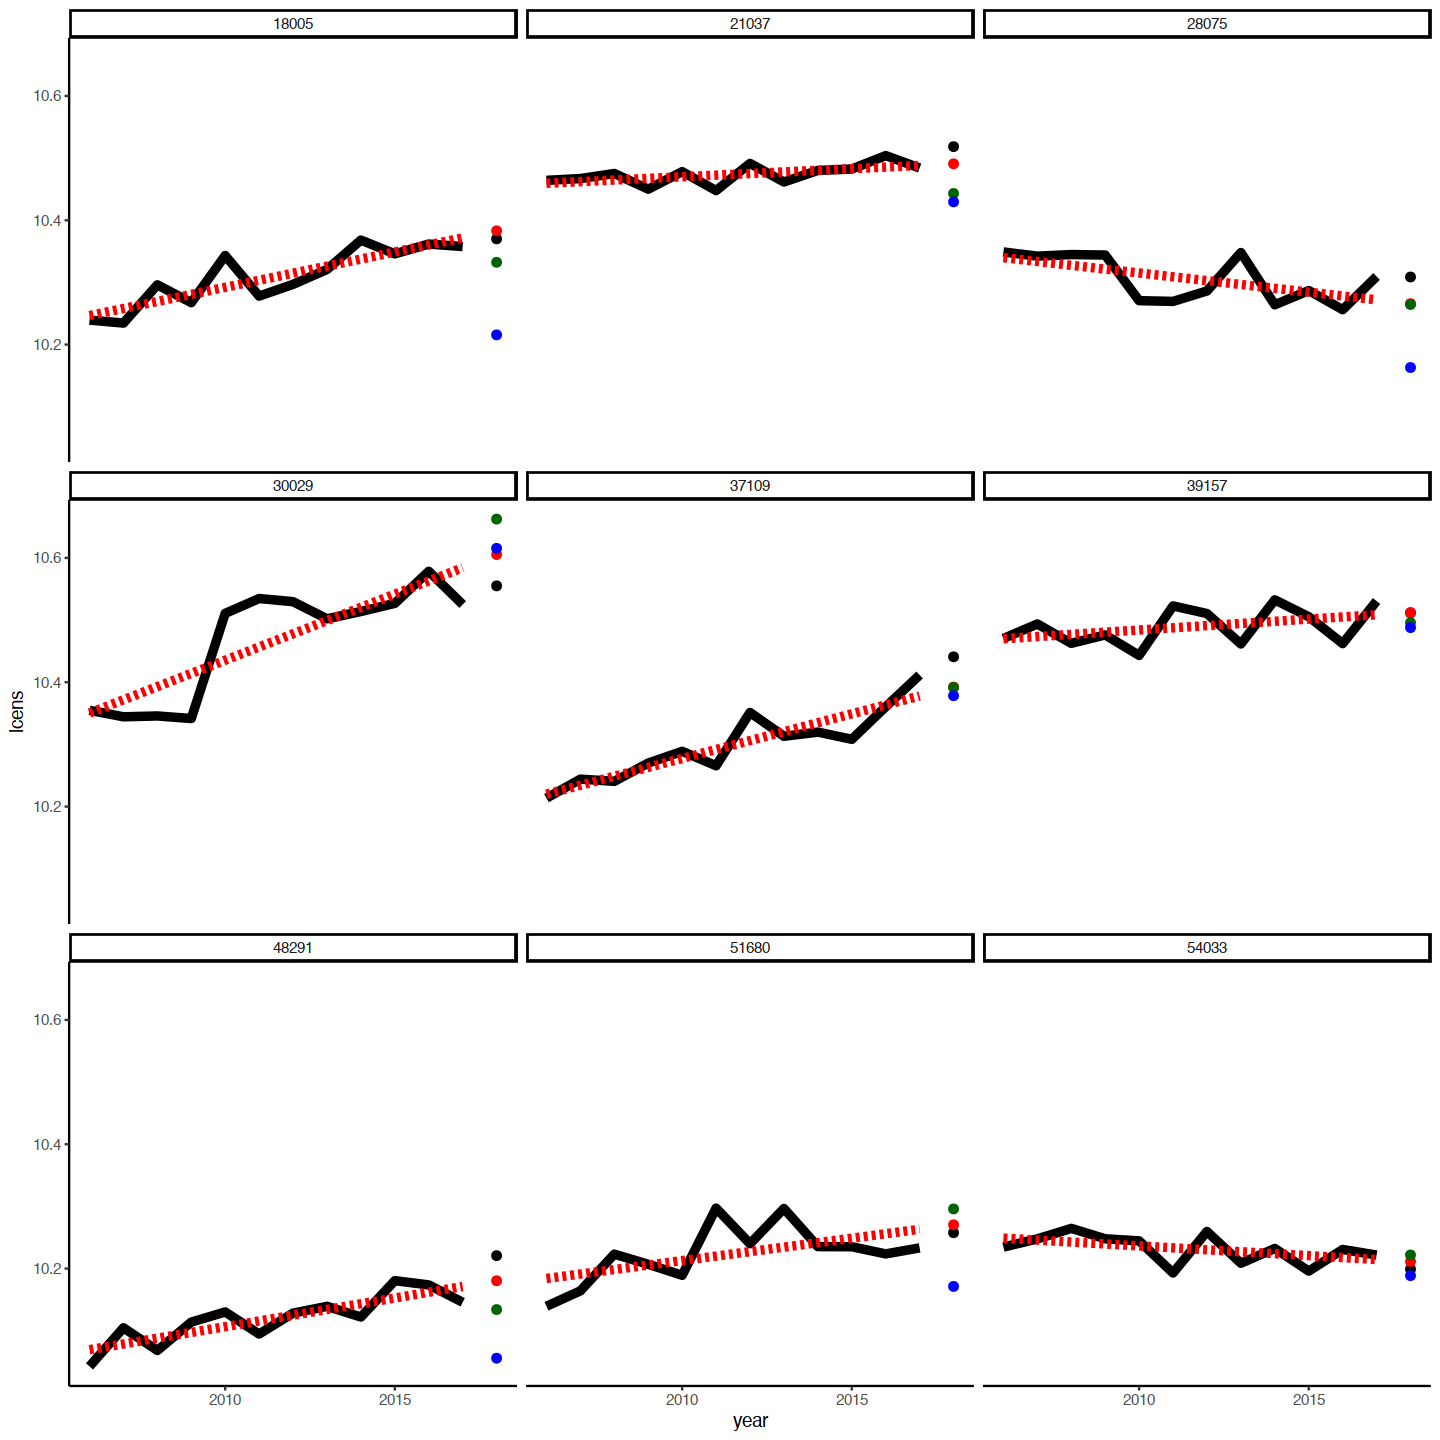

In [69]:
options(repr.plot.width=12, repr.plot.height=12)

# split the data by population decile
res <- res %>%
    mutate(acs_quartile = quantcut(lcens, q = 4, na.rm = TRUE))
levels(res$acs_quartile) <- c(1:4)

countyids <- res %>% 
    filter(acs_quartile == 1) %>%
    sample_n(9) %>%
    .$countyid

res_samp <- res %>%
    filter(countyid %in% countyids)
tr_samp <- train %>%
    filter(countyid %in% countyids)

ggplot() +
    geom_line(
        data = tr_samp,
        aes(x = year, y = lcens),
        size = 2
    ) +
    geom_smooth(
        data = tr_samp,
        aes(x = year, y = lcens),
        method = "lm",
        fill = NA, 
        color = 'red',
        linetype = 'dashed',
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lcens),
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = .mean),
        color = 'red',
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lprd_4),
        color = 'darkgreen',
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lig),
        color = 'blue',
        size = 2
    ) +
    facet_wrap(. ~ countyid) +
    theme_classic()